In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
import scipy

In [2]:
l1 = np.random.normal(size=100000)
l2 = np.random.normal(size=100000)
l3 = np.random.normal(size=100000)

latents = np.array([l1, l1*0.5, l1*0.25, l2*0.7, l2*0.3, l3*0.5]).T
X = latents + np.random.normal(size=6 * 100000).reshape((100000, 6))*0.5
Y = latents + np.random.normal(size=6 * 100000).reshape((100000, 6))*0.5

X = X-X.mean(axis=0)
Y = Y-Y.mean(axis=0)

In [3]:
cca = CCA(n_components=3,scale = False, max_iter=1000)
cca.fit(X, Y)
X_c, Y_c = cca.transform(X, Y)
cca_corr_1 = np.corrcoef(X_c.T,Y_c.T)[3,0]
cca_corr_2 = np.corrcoef(X_c.T,Y_c.T)[4,1]
cca_corr_3 = np.corrcoef(X_c.T,Y_c.T)[5,2]

In [4]:
c12 = X.T@Y
c11 = X.T@X
c22 = Y.T@Y


eigenvalue,eigenvector = np.linalg.eig(c11)
c11_inv_sqrt = scipy.linalg.inv(scipy.linalg.sqrtm(c11))

eigenvalue,eigenvector = np.linalg.eig(c22)
c22_inv_sqrt = scipy.linalg.inv(scipy.linalg.sqrtm(c22))

R = c11_inv_sqrt@c12@c22_inv_sqrt
eigenvalue,eigenvector = np.linalg.eig(R.T@R)

a_t = c11_inv_sqrt@eigenvector[:,:3]
b_t = c22_inv_sqrt@eigenvector[:,:3]

X_t = X@a_t
Y_t = Y@b_t

my_cca_corr_1 = np.corrcoef(X_t.T,Y_t.T)[3,0]
my_cca_corr_2 = np.corrcoef(X_t.T,Y_t.T)[4,1]
my_cca_corr_3 = np.corrcoef(X_t.T,Y_t.T)[5,2]

In [5]:
a = np.random.randn(6,3)
a,_ = np.linalg.qr(a, mode='reduced')
b = np.random.randn(6,3)
b,_ = np.linalg.qr(b, mode='reduced')

corr_list_1 = []
corr_list_2 = []
corr_list_3 = []

eta = 0.00025
for j in range(0,300):
    for i in range(100):

        ind = j*100+i
        x = X[ind,:]
        y = Y[ind,:]

        c12 = np.outer(x,y)

        a += eta*c12@b
        a,ar = np.linalg.qr(a, mode='reduced')
        a[:,0] = a[:,0]/np.sqrt(a[:,0].T@X[:ind+1,:].T@X[:ind+1,:]@a[:,0])
        a[:,1] = a[:,1]/np.sqrt(a[:,1].T@X[:ind+1,:].T@X[:ind+1,:]@a[:,1])
        a[:,2] = a[:,2]/np.sqrt(a[:,2].T@X[:ind+1,:].T@X[:ind+1,:]@a[:,2])
        a = a*np.sign(np.diagonal(ar))

        b += eta*c12.T@a
        b,br = np.linalg.qr(b, mode='reduced')
        b[:,0] = b[:,0]/np.sqrt(b[:,0].T@Y[:ind+1,:].T@Y[:ind+1,:]@b[:,0])
        b[:,1] = b[:,1]/np.sqrt(b[:,1].T@Y[:ind+1,:].T@Y[:ind+1,:]@b[:,1])
        b[:,2] = b[:,2]/np.sqrt(b[:,2].T@Y[:ind+1,:].T@Y[:ind+1,:]@b[:,2])
        b = b*np.sign(np.diagonal(br))

    X_s = X@a
    Y_s = Y@b    
    corr_list_1.append(np.corrcoef(X_s.T,Y_s.T)[3,0])
    corr_list_2.append(np.corrcoef(X_s.T,Y_s.T)[4,1])
    corr_list_3.append(np.corrcoef(X_s.T,Y_s.T)[5,2])

eta = 0.0004
for j in range(300,1000):
    for i in range(100):

        ind = j*100+i
        x = X[ind,:]
        y = Y[ind,:]

        c12 = np.outer(x,y)

        a += eta*c12@b
        a,ar = np.linalg.qr(a, mode='reduced')
        a[:,0] = a[:,0]/np.sqrt(a[:,0].T@X[:ind+1,:].T@X[:ind+1,:]@a[:,0])
        a[:,1] = a[:,1]/np.sqrt(a[:,1].T@X[:ind+1,:].T@X[:ind+1,:]@a[:,1])
        a[:,2] = a[:,2]/np.sqrt(a[:,2].T@X[:ind+1,:].T@X[:ind+1,:]@a[:,2])
        a = a*np.sign(np.diagonal(ar))

        b += eta*c12.T@a
        b,br = np.linalg.qr(b, mode='reduced')
        b[:,0] = b[:,0]/np.sqrt(b[:,0].T@Y[:ind+1,:].T@Y[:ind+1,:]@b[:,0])
        b[:,1] = b[:,1]/np.sqrt(b[:,1].T@Y[:ind+1,:].T@Y[:ind+1,:]@b[:,1])
        b[:,2] = b[:,2]/np.sqrt(b[:,2].T@Y[:ind+1,:].T@Y[:ind+1,:]@b[:,2])
        b = b*np.sign(np.diagonal(br))

    X_s = X@a
    Y_s = Y@b    
    corr_list_1.append(np.corrcoef(X_s.T,Y_s.T)[3,0])
    corr_list_2.append(np.corrcoef(X_s.T,Y_s.T)[4,1])
    corr_list_3.append(np.corrcoef(X_s.T,Y_s.T)[5,2])

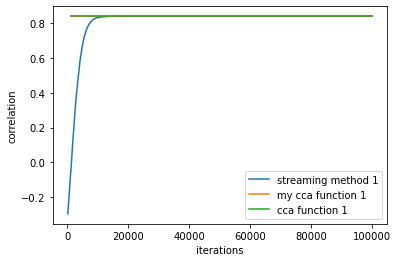

In [6]:
plt.plot(np.array(list(range(1,1001)))*100,corr_list_1,label='streaming method 1')
plt.plot([1000,100000],[my_cca_corr_1,my_cca_corr_1],label='my cca function 1')
plt.plot([1000,100000],[cca_corr_1,cca_corr_1],label='cca function 1')
plt.xlabel('iterations')
plt.ylabel('correlation')
plt.legend()
plt.show()

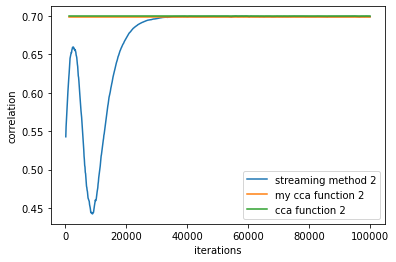

In [7]:
plt.plot(np.array(list(range(1,1001)))*100,corr_list_2,label='streaming method 2')
plt.plot([1000,100000],[my_cca_corr_2,my_cca_corr_2],label='my cca function 2')
plt.plot([1000,100000],[cca_corr_2,cca_corr_2],label='cca function 2')
plt.xlabel('iterations')
plt.ylabel('correlation')
plt.legend()
plt.show()

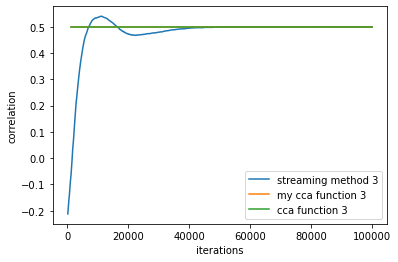

In [8]:
plt.plot(np.array(list(range(1,1001)))*100,corr_list_3,label='streaming method 3')
plt.plot([1000,100000],[my_cca_corr_3,my_cca_corr_3],label='my cca function 3')
plt.plot([1000,100000],[cca_corr_3,cca_corr_3],label='cca function 3')
plt.xlabel('iterations')
plt.ylabel('correlation')
plt.legend()
plt.show()

In [9]:
print(a_t/np.linalg.norm(a_t,axis=0))

[[-0.87284363 -0.00843754 -0.00212596]
 [-0.43460603  0.01006348 -0.00638015]
 [-0.22151678  0.00132179  0.00307648]
 [ 0.00569921 -0.91767993  0.00655193]
 [ 0.00293833 -0.39709924 -0.00804099]
 [-0.01228024  0.00123777  0.99991886]]


In [10]:
print(cca.x_weights_)

[[ 8.72802843e-01  2.03234624e-03 -4.12719175e-03]
 [ 4.37319659e-01  5.92739985e-03 -1.22426986e-02]
 [ 2.16323716e-01 -3.26319400e-03 -6.30392433e-03]
 [-5.07054833e-04  9.19021463e-01  4.57359732e-03]
 [-8.08866556e-03  3.94143748e-01 -9.02407796e-03]
 [ 1.02507960e-02 -5.86156432e-04  9.99845484e-01]]


In [11]:
print(a/np.linalg.norm(a,axis=0))

[[-0.86867546  0.01468768  0.00934654]
 [-0.44352566 -0.00529486  0.00545668]
 [-0.22000071  0.00551342 -0.00208442]
 [ 0.00784214  0.91818955 -0.00118133]
 [ 0.01091505  0.39566718 -0.0229279 ]
 [ 0.0103436   0.01006287  0.99967567]]
